# Guided LDA
https://www.kaggle.com/code/nvpsani/topic-modelling-using-guided-lda

In [1]:
import numpy as np
import s3fs
import boto3
import pandas as pd
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')

import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer

import guidedlda

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ec2-user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#import data
model_data = pd.read_csv('s3://book-data-ucb-capstone-s2022/LDA_train.csv')
print('Tokenized Text DF Size:', len(model_data))

Tokenized Text DF Size: 28652


/tmp/ipykernel_16308/1016882758.py:2: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  model_data = pd.read_csv('s3://book-data-ucb-capstone-s2022/LDA_train.csv')


In [3]:
#sample model data
model_data = model_data.sample(frac=0.25)

In [4]:
model_data.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,bookId,title,series,author,rating,description,language,...,Fantasy,Erotica,History,Dystopia,Poetry,Biography,Manga,Thriller,Graphic Novels,Romance
23615,24615,24615,38044,21432474-wraith,Wraith,Welcome to Christmasland #1-6,"Joe Hill (Goodreads Author), Charles Paul Wils...",4.12,"Joe Hill's New York Times Bestselling novel, N...",English,...,Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,Thriller,Graphic Novels,NaN
2386,3386,3386,25149,23208397-underground-airlines,Underground Airlines,NaN,Ben H. Winters (Goodreads Author),3.83,A young black man calling himself Victor has s...,English,...,Fantasy,NaN,NaN,Dystopia,NaN,NaN,NaN,Thriller,NaN,NaN
6189,7189,7189,3150,11267847-a-job-from-hell,A Job From Hell,Ancient Legends #1,Jayde Scott (Goodreads Author),3.55,The moment Amber starts her summer job in Scot...,English,...,Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Romance
27910,28910,28910,27996,1081976.Dead_Heat,Dead Heat,NaN,"Dick Francis, Felix Francis (Goodreads Author)",3.86,Max Moreton is a rising culinary star and his ...,English,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thriller,NaN,NaN
24830,25830,25830,6456,787660.Heaven,Heaven,Casteel #1,V.C. Andrews,4.03,"Of all the folks in the mountain shacks, the C...",English,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thriller,NaN,Romance


In [5]:
#preprocessing
def preprocess_text(text):

  #lowercase text
  text_preprocessed = text.lower()
  #remove punctuation
  text_preprocessed = re.sub(r'[^a-zA-Z ]+', '', text_preprocessed)
  #tokenize for stopword removal
  text_preprocessed = word_tokenize(text_preprocessed)
  #remove stopwords
  text_preprocessed = [word for word in text_preprocessed if word not in stopwords.words('english')]
  #join to make string again
  #text_preprocessed = (" ").join(text_preprocessed)

  return text_preprocessed

In [11]:
%%time
model_data['tokens'] = model_data['description'].apply(lambda x: preprocess_text(x))

CPU times: user 1min 16s, sys: 5.51 s, total: 1min 22s
Wall time: 1min 22s


## Synsets

In [12]:
def create_synsets(event):
  
  synonym = [] 
    
  for synset in wordnet.synsets(event): 
      for i in synset.lemmas(): 
          synonym.append(i.name()) # add all the synonyms available 
    
  return synonym

In [13]:
#creating library dataframe

#creating library dataframe


life_events = ['university', 'relationships', 'break ups', 'divorce', 'wedding', 
               'death', 'family', 'friendship', 'marriage']

#create synsets for select events where decent synsets exist
relationship_list = create_synsets('go_steady') + ['relationship', 'kinship', 'romance', 'dating']
marriage_list = create_synsets('marriage')
wedding_list = create_synsets('wedding') + ['matrimony']

#replace underscore (_) with space
relationship_list = [i.replace("_", " ") for i in relationship_list]
marriage_list = [i.replace("_", " ") for i in marriage_list]
wedding_list = [i.replace("_", " ") for i in wedding_list]

#remove certain words
wedding_list.remove('tie')
wedding_list.remove('marriage')
relationship_list.remove('see')

synsets = [['college', 'university', 'campus', 'academia', 'professor', 'colleges', 'universities', 'professors'], 
           relationship_list, 
           ['breakup', 'break up', 'split up', 'broken up', 'dumped', 'breaks up', 'splits up', 'dumps', 'dump', 'breaks off', 'break off'], 
           ['divorce', 'divorced', 'divorces'], 
           wedding_list,  
           ['death', 'decease', 'deceased', 'dying'],
           ['family', 'mother', 'father', 'brother', 'sister', 'mom', 'dad'],
           ['friends', 'friend', 'friendship', 'friendships'],
           marriage_list]

# Create the pandas DataFrame with column name is provided explicitly
df_lib = pd.DataFrame(life_events, columns=['life_event'])
df_lib['synsets'] = synsets
 
# print dataframe.
df_lib

,life_event,synsets
0,university,"[college, university, campus, academia, profes..."
1,relationships,"[go steady, go out, date, relationship, kinshi..."
2,break ups,"[breakup, break up, split up, broken up, dumpe..."
3,divorce,"[divorce, divorced, divorces]"
4,wedding,"[wedding, wedding ceremony, nuptials, hymeneal..."
5,death,"[death, decease, deceased, dying]"
6,family,"[family, mother, father, brother, sister, mom,..."
7,friendship,"[friends, friend, friendship, friendships]"
8,marriage,"[marriage, matrimony, union, spousal relations..."


## Guided LDA

In [14]:
#create objects required for model training

model_data['liststring'] = [','.join(map(str, l)) for l in model_data['tokens']]
corpus=model_data['liststring'].tolist()
vocab=list(set(word_tokenize(" ".join(model_data['liststring']))))
vectorizer = CountVectorizer(ngram_range=(1,2),vocabulary=vocab)
X = vectorizer.fit_transform(corpus)
word2id=vectorizer.vocabulary_

#synsets unigrams only

#define model
model = guidedlda.GuidedLDA(n_topics=8, n_iter=2000, random_state=7, refresh=20,alpha=0.01,eta=0.01)

synsets = [['college', 'university', 'campus', 'professor', 'professors'], 
           ['date', 'relationship', 'romance', 'dating'],
           ['breakup', 'dumped'], 
           ['divorce', 'divorced'], 
           ['wedding', 'nuptials', 'wedding', 'wedding', 'marry', 'wed', 'marry', 'wed'], 
           ['death', 'deceased', 'dying'],
           ['family', 'mother', 'father', 'brother', 'sister', 'mom', 'dad'],
           ['friends', 'friend', 'friendship', 'friendships']]

seed_topics = {}
for t_id, st in enumerate(synsets):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
corpus=model_data['liststring'].tolist()

In [ ]:
vocab=list(set(word_tokenize(" ".join(model_data['liststring']))))

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1,1),vocabulary=vocab)

In [ ]:
X = vectorizer.fit_transform(corpus)

In [ ]:
word2id=vectorizer.vocabulary_

In [ ]:
#define model
model = guidedlda.GuidedLDA(n_topics=8, n_iter=2000, random_state=7, refresh=20,alpha=0.01,eta=0.01)

In [ ]:
#synsets for sampled data

synsets = [['college', 'university', 'campus', 'professor', 'professors'], 
           ['date', 'relationship', 'romance', 'dating'],
           ['breakup', 'dumped'], 
           ['divorce', 'divorced'], 
           ['wedding', 'nuptials', 'wedding', 'wedding', 'marry', 'wed', 'marry', 'wed'], 
           ['death', 'deceased', 'dying'],
           ['family', 'mother', 'father', 'brother', 'sister', 'mom', 'dad'],
           ['friends', 'friend', 'friendship', 'friendships']]

## Set Priors

In [ ]:
seed_topics = {}
for t_id, st in enumerate(synsets):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
seed_topics

## Train Model

In [15]:
%%time
model.fit(X, seed_topics=seed_topics, seed_confidence=0.15)

INFO:guidedlda:n_documents: 7163
INFO:guidedlda:vocab_size: 62479
INFO:guidedlda:n_words: 561209
INFO:guidedlda:n_topics: 8
INFO:guidedlda:n_iter: 2000
INFO:guidedlda:<0> log likelihood: -6923484
INFO:guidedlda:<20> log likelihood: -5775077
INFO:guidedlda:<40> log likelihood: -5676594
INFO:guidedlda:<60> log likelihood: -5627426
INFO:guidedlda:<80> log likelihood: -5597899
INFO:guidedlda:<100> log likelihood: -5577307
INFO:guidedlda:<120> log likelihood: -5562690
INFO:guidedlda:<140> log likelihood: -5551161
INFO:guidedlda:<160> log likelihood: -5542992
INFO:guidedlda:<180> log likelihood: -5531798
INFO:guidedlda:<200> log likelihood: -5525857
INFO:guidedlda:<220> log likelihood: -5518362
INFO:guidedlda:<240> log likelihood: -5513133
INFO:guidedlda:<260> log likelihood: -5509713
INFO:guidedlda:<280> log likelihood: -5504538
INFO:guidedlda:<300> log likelihood: -5500581
INFO:guidedlda:<320> log likelihood: -5494100
INFO:guidedlda:<340> log likelihood: -5492091
INFO:guidedlda:<360> log l

CPU times: user 1min 8s, sys: 43.7 ms, total: 1min 8s
Wall time: 1min 8s


## Seeing the model output topics and up to 10 words per topic

In [16]:
n_top_words = 10
topic_word = model.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: book series new first bestselling world story author books readers
Topic 1: de london lady la society jane elizabeth good would handsome
Topic 2: novel story book world first one life new work human
Topic 3: christmas lily like nate get song bobby good rose weston
Topic 4: one new murder killer case mystery death detective police dead
Topic 5: world must one power war magic new time dark evil
Topic 6: love life family young one story man new woman years
Topic 7: life one shes love new hes even like never get


## Assigning the Topics

In [17]:
topic_num_name = {"Topic 0":"university",
                  "Topic 1":"relationships",
                  "Topic 2":"breakups",
                  "Topic 3":"divorce",
                  "Topic 4":"wedding",
                  "Topic 5": "death",
                  "Topic 6": "family",
                  "Topic 7": "friends"}    

In [18]:
def get_doc_topics(model_glda,X,num_topics,dataframe,col_name):
    """
    A function which creates dataframe with documents, their dominant topic, along with their probabilities
    
    Parameters
    -------------
    model_glda - Guided LDA trained model
    X - Document term frequency table
    num_topics - Number of topics the model was trained for
    dataframe - Dataframe consisting of cleaned text column
    col_name - Column name in dataframe holding cleaned text
    
    Returns
    -------------
    A dataframe with document number, topic, probability of topic
    """
    df_doc_top = pd.DataFrame()
    final_list = []
    for index in range(len(dataframe[col_name])):
        word_id_dict = dict((x,y) for x,y in zip([x for x in range(num_topics)],np.round(model.transform(X[index])*100,1).tolist()[0]))
        word_score_list = []
        for index in range(num_topics):
            try:
                value = word_id_dict[index]
            except:
                value = 0
            word_score_list.append(value)
        final_list.append(word_score_list)

    df_doc_top = pd.DataFrame(final_list)
    df_doc_top.columns = ['Topic ' + str(i) for i in range(num_topics)]
    df_doc_top.index = ['Document ' + str(i) for i in range(len(dataframe[col_name]))]

    df_doc_top["Dominant_Topic"] = df_doc_top.idxmax(axis=1).tolist()
    df_doc_top["Topic_Probability"] = df_doc_top.max(axis=1).tolist()
    #document_df = df_doc_top.reset_index().rename(columns={"index":"Document"})[["Document","Dominant_Topic","Topic_Probability"]]


    #return document_df
    return df_doc_top

In [19]:
X.shape

(7163, 62479)

In [20]:
%%time

#ignore warning
import warnings
warnings.filterwarnings("ignore")

document_df=get_doc_topics(model,X,8,model_data,"liststring")

CPU times: user 17.3 s, sys: 2.1 s, total: 19.4 s
Wall time: 16.6 s


In [21]:
document_df['description']= model_data['description']

In [22]:
#output in dictionary format for each row in df
    #key: topic; value: prob
document_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Dominant_Topic,Topic_Probability,description
Document 0,73.3,0.0,0.0,0.4,0.0,0.0,2.2,24.1,Topic 0,73.3,NaN
Document 1,0.0,0.0,14.5,0.0,48.8,2.2,1.3,33.1,Topic 4,48.8,NaN
Document 2,15.1,0.2,0.0,0.0,0.0,49.9,0.1,34.7,Topic 5,49.9,NaN
Document 3,0.0,22.2,10.1,0.2,1.2,21.5,43.0,1.8,Topic 6,43.0,NaN
Document 4,0.0,15.0,0.0,0.0,0.0,0.4,31.4,53.2,Topic 7,53.2,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Document 7158,0.0,0.0,0.0,6.0,0.0,26.4,0.0,67.6,Topic 7,67.6,NaN
Document 7159,0.0,0.0,0.0,0.0,0.0,46.3,53.6,0.0,Topic 6,53.6,NaN
Document 7160,0.0,26.4,0.0,0.0,0.0,0.0,0.1,73.5,Topic 7,73.5,NaN
Document 7161,1.4,0.0,0.0,5.2,26.5,53.5,0.5,13.0,Topic 5,53.5,NaN


In [23]:
document_df.Dominant_Topic.value_counts()

Topic 7    2766
Topic 6    1479
Topic 5    1331
Topic 2     650
Topic 4     420
Topic 0     410
Topic 1      67
Topic 3      40
Name: Dominant_Topic, dtype: int64

## Run the Test Set

In [102]:
#import test set

#import data
model_data_test = pd.read_csv('s3://book-data-ucb-capstone-s2022/LDA_test.csv')


print('Tokenized Text DF Size:', len(model_data_test))

Tokenized Text DF Size: 1000


In [83]:
model_data_test.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'index', 'Unnamed: 0', 'bookId',
       'title', 'series', 'author', 'rating', 'description', 'language',
       'isbn', 'genres', 'characters', 'bookFormat', 'edition', 'pages',
       'publisher', 'publishDate', 'firstPublishDate', 'awards', 'numRatings',
       'ratingsByStars', 'likedPercent', 'setting', 'coverImg', 'bbeScore',
       'bbeVotes', 'price', 'Fiction', 'Nonfiction', 'Young Adult',
       'Childrens', 'New Adult', 'Fantasy', 'Erotica', 'History', 'Dystopia',
       'Poetry', 'Biography', 'Manga', 'Thriller', 'Graphic Novels', 'Romance',
       'university', 'relationships', 'break ups', 'divorce', 'weddings',
       'death', 'family', 'friendship', 'labeled? ', 'Contains True?'],
      dtype='object')

In [84]:
%%time
model_data_test['tokens'] = model_data_test['description'].apply(lambda x: preprocess_text(x))

CPU times: user 10.6 s, sys: 710 ms, total: 11.3 s
Wall time: 11.3 s


In [85]:
#create objects required for model training

model_data_test['liststring'] = [','.join(map(str, l)) for l in model_data_test['tokens']]
corpus=model_data_test['liststring'].tolist()
vocab=list(set(word_tokenize(" ".join(model_data_test['liststring']))))
vectorizer = CountVectorizer(ngram_range=(1,2),vocabulary=vocab)
X = vectorizer.fit_transform(corpus)
word2id=vectorizer.vocabulary_


In [86]:
#synsets unigrams only

synsets = [['college', 'university', 'campus', 'professor', 'professors'], 
           ['date', 'relationship', 'romance', 'dating'],
           ['breakup', 'dumped', 'dump'], 
           ['divorce', 'divorced'], 
           ['wedding', 'wedding', 'wedding', 'marry', 'wed', 'marry', 'wed'], 
           ['death', 'deceased', 'dying'],
           ['family', 'mother', 'father', 'brother', 'sister', 'mom', 'dad'],
           ['friends', 'friend', 'friendship', 'friendships']]


seed_topics = {}
for t_id, st in enumerate(synsets):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [87]:
topic_list = ['universities', 'relationships', 'break ups', 'divorce', 'wedding', 'death', 'family', 'friendship']


In [88]:
document_df_test=get_doc_topics(model,X,8,model_data_test,"liststring")

In [89]:
document_df_test

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Dominant_Topic,Topic_Probability
Document 0,5.9,12.6,10.4,7.6,16.9,10.7,11.2,24.7,Topic 7,24.7
Document 1,11.1,8.8,14.0,20.7,6.7,20.8,17.4,0.5,Topic 5,20.8
Document 2,14.0,9.8,12.2,16.4,6.5,20.6,10.7,9.8,Topic 5,20.6
Document 3,4.6,22.1,15.6,1.2,4.2,18.4,17.2,16.6,Topic 1,22.1
Document 4,11.8,16.5,8.8,6.1,6.0,16.9,16.9,17.0,Topic 7,17.0
...,...,...,...,...,...,...,...,...,...,...
Document 995,6.6,14.6,10.4,7.3,12.4,14.4,19.4,14.9,Topic 6,19.4
Document 996,9.0,7.2,17.0,8.1,6.0,13.5,18.3,21.1,Topic 7,21.1
Document 997,13.1,27.3,23.8,0.0,2.4,12.2,14.3,6.9,Topic 1,27.3
Document 998,16.0,22.3,9.0,3.1,10.2,14.7,13.9,10.7,Topic 1,22.3


In [90]:
topic_list = ['university', 'relationships', 'break ups', 'divorce', 'wedding', 'death', 'family', 'friendship', 'Dominant_Topic', 'Topic_Probability']


In [91]:
document_df_test.columns = topic_list

In [92]:
document_df_test.head()

,university,relationships,break ups,divorce,wedding,death,family,friendship,Dominant_Topic,Topic_Probability
Document 0,5.9,12.6,10.4,7.6,16.9,10.7,11.2,24.7,Topic 7,24.7
Document 1,11.1,8.8,14.0,20.7,6.7,20.8,17.4,0.5,Topic 5,20.8
Document 2,14.0,9.8,12.2,16.4,6.5,20.6,10.7,9.8,Topic 5,20.6
Document 3,4.6,22.1,15.6,1.2,4.2,18.4,17.2,16.6,Topic 1,22.1
Document 4,11.8,16.5,8.8,6.1,6.0,16.9,16.9,17.0,Topic 7,17.0


In [93]:
#turn prds into True/False
preds = document_df_test[['university', 'relationships', 'break ups', 'divorce', 'wedding', 'death', 'family', 'friendship']]
cols = ['university', 'relationships', 'break ups', 'divorce', 'wedding', 'death', 'family', 'friendship']

for col_name in cols:
    preds[col_name] =  preds[col_name] > 20

preds.head()

,university,relationships,break ups,divorce,wedding,death,family,friendship
Document 0,False,False,False,False,False,False,False,True
Document 1,False,False,False,True,False,True,False,False
Document 2,False,False,False,False,False,True,False,False
Document 3,False,True,False,False,False,False,False,False
Document 4,False,False,False,False,False,False,False,False


In [94]:
preds['friendship'].value_counts()

False    867
True     133
Name: friendship, dtype: int64

In [95]:
model_data_test['friendship'].value_counts()

True     191
False    156
Name: friendship, dtype: int64

In [96]:
model_data_test.head(100)

,Unnamed: 0.2,Unnamed: 0.1,index,Unnamed: 0,bookId,title,series,author,rating,description,...,break ups,divorce,weddings,death,family,friendship,labeled?,Contains True?,tokens,liststring
0,0,0,0,"39,822",34838660-not-part-of-the-plan,Not Part of the Plan,Blue Moon #4,Lucy Score (Goodreads Author),4.46,From the Wall Street Journal and #1 Amazon bes...,...,False,False,False,False,False,False,Yes,1.0,"[wall, street, journal, amazon, bestselling, a...","wall,street,journal,amazon,bestselling,author,..."
1,1,1,1,"34,235",20176552-dragon-age-volume-1,"Dragon Age, Volume 1",Dragon Age Graphic Novels #1-3,"David Gaider, Chad Hardin (Illustrator), Antho...",4.26,Helping set the stage for BioWare's hotly anti...,...,False,False,False,False,False,False,Yes,0.0,"[helping, set, stage, biowares, hotly, anticip...","helping,set,stage,biowares,hotly,anticipated,d..."
2,2,2,2,"27,904",124110.Dangerous_to_Know,Dangerous to Know,NaN,Barbara Taylor Bradford (Goodreads Author),3.73,"Sebastian Locke, the fifty-six-year-old patria...",...,False,True,False,True,True,False,Yes,1.0,"[sebastian, locke, fiftysixyearold, patriarch,...","sebastian,locke,fiftysixyearold,patriarch,powe..."
3,3,3,3,"10,515",1046450.The_Wheel_of_Fortune,The Wheel of Fortune,NaN,Susan Howatch,4.11,"""Take me back to Oxmoon, the lost paradise of ...",...,False,False,False,False,True,False,Yes,1.0,"[take, back, oxmoon, lost, paradise, childhood...","take,back,oxmoon,lost,paradise,childhood,take,..."
4,4,4,4,935,872333.Blue_Bloods,Blue Bloods,Blue Bloods #1,Melissa de la Cruz (Goodreads Author),3.69,"When the Mayflower set sail in 1620, it carrie...",...,False,False,False,False,False,False,Yes,0.0,"[mayflower, set, sail, carried, board, men, wo...","mayflower,set,sail,carried,board,men,women,wou..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,95,95,"29,900",6531211-pregnant-pause,Pregnant Pause,NaN,Han Nolan,3.76,A thought-provoking and courageous new novel b...,...,NaN,NaN,True,NaN,True,NaN,NaN,1.0,"[thoughtprovoking, courageous, new, novel, nat...","thoughtprovoking,courageous,new,novel,national..."
96,96,96,96,"20,513",2620105-the-mystery-of-the-martello-tower,The Mystery of the Martello Tower,NaN,Jennifer Lanthier,3.81,Hazel and Ned are home for summer vacation and...,...,False,False,False,False,True,False,Yes,1.0,"[hazel, ned, home, summer, vacation, looking, ...","hazel,ned,home,summer,vacation,looking,forward..."
97,97,97,97,"40,741",10842675-waiting-for-the-magic,Waiting for the Magic,NaN,"Patricia MacLachlan, Amy June Bates",4.03,People may drift apart\nBut love can hold them...,...,NaN,NaN,NaN,NaN,True,NaN,NaN,1.0,"[people, may, drift, apartbut, love, hold, tog...","people,may,drift,apartbut,love,hold,togetherso..."
98,98,98,98,"7,112",19504931-under-different-stars,Under Different Stars,Kricket #1,Amy A. Bartol (Goodreads Author),4.21,Kricket Hollowell is normally not one to wish ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,"[kricket, hollowell, normally, one, wish, upon...","kricket,hollowell,normally,one,wish,upon,stars..."


## Run Evaluation Code

In [97]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import numpy as np
from copy import copy

In [108]:
#replace nans with false
cols = ['university', 'relationships', 'break ups', 'divorce', 'weddings', 'death', 'family', 'friendship']

for col_name in cols:
    model_data_test[col_name] =  model_data_test[col_name].fillna(False)

model_data_test['wedding'] = model_data_test['weddings']

In [109]:
model_data_test.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'index', 'Unnamed: 0', 'bookId',
       'title', 'series', 'author', 'rating', 'description', 'language',
       'isbn', 'genres', 'characters', 'bookFormat', 'edition', 'pages',
       'publisher', 'publishDate', 'firstPublishDate', 'awards', 'numRatings',
       'ratingsByStars', 'likedPercent', 'setting', 'coverImg', 'bbeScore',
       'bbeVotes', 'price', 'Fiction', 'Nonfiction', 'Young Adult',
       'Childrens', 'New Adult', 'Fantasy', 'Erotica', 'History', 'Dystopia',
       'Poetry', 'Biography', 'Manga', 'Thriller', 'Graphic Novels', 'Romance',
       'university', 'relationships', 'break ups', 'divorce', 'weddings',
       'death', 'family', 'friendship', 'labeled? ', 'Contains True?',
       'wedding'],
      dtype='object')

In [110]:
def eval_func(results, true_labels):
    LE_metrics = [] #returns confusion matrix and metrics for each life_event, need to add overall 
    eval_dict = {}
    for life_event in ['university', 'relationships', 'break ups', 'divorce', 'wedding', 'death', 'family', 'friendship']:
        cm = confusion_matrix(true_labels[life_event], results[life_event], labels=[False, True])
        TN, FP, FN, TP = cm.ravel()
        print(life_event.upper(), " Confusion Matrix")
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        eval_dict['Recall or TPR'] = copy(TPR)
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        eval_dict['Specificity or TNR'] = copy(TNR)
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        eval_dict['Precision or PPV'] = copy(PPV)
        # Negative predictive value
        NPV = TN/(TN+FN)
        eval_dict['Negative Predictive Value'] = copy(NPV)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        eval_dict['False Positive Rate'] = copy(FPR)
        # False negative rate
        FNR = FN/(TP+FN)
        eval_dict['False Negative Rate'] = copy(FNR)
        # False discovery rate
        FDR = FP/(TP+FP)
        eval_dict['False Discovery Rate'] = copy(FDR)
        # Overall accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)
        eval_dict['Accuracy'] = copy(ACC)
        LE_metrics.append(copy(eval_dict))
    df = pd.DataFrame.from_records(LE_metrics, index = ['university', 'relationships', 'break ups', 'divorce', 'wedding', 'death', 'family', 'friendship'])
    return df

UNIVERSITY  Confusion Matrix


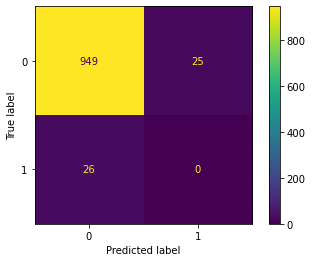

RELATIONSHIPS  Confusion Matrix


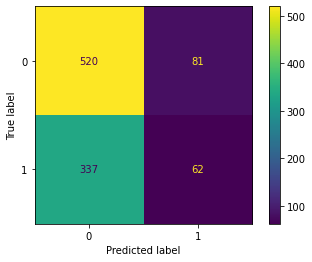

BREAK UPS  Confusion Matrix


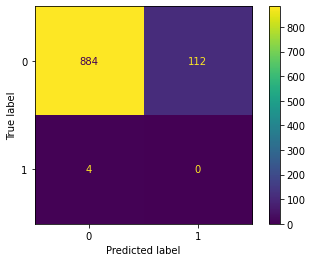

DIVORCE  Confusion Matrix


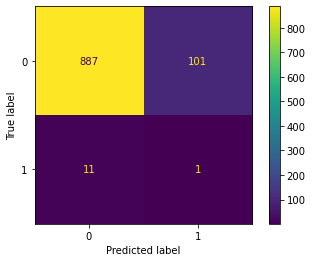

WEDDING  Confusion Matrix


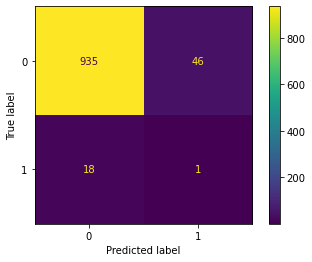

DEATH  Confusion Matrix


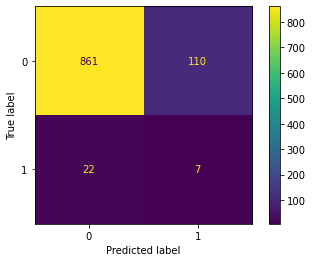

FAMILY  Confusion Matrix


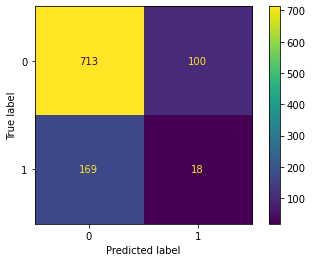

FRIENDSHIP  Confusion Matrix


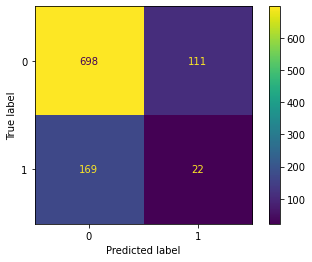

,Recall or TPR,Specificity or TNR,Precision or PPV,Negative Predictive Value,False Positive Rate,False Negative Rate,False Discovery Rate,Accuracy
university,0.000000,0.974333,0.000000,0.973333,0.025667,1.000000,1.000000,0.949
relationships,0.155388,0.865225,0.433566,0.606768,0.134775,0.844612,0.566434,0.582
break ups,0.000000,0.887550,0.000000,0.995495,0.112450,1.000000,1.000000,0.884
divorce,0.083333,0.897773,0.009804,0.987751,0.102227,0.916667,0.990196,0.888
wedding,0.052632,0.953109,0.021277,0.981112,0.046891,0.947368,0.978723,0.936
death,0.241379,0.886715,0.059829,0.975085,0.113285,0.758621,0.940171,0.868
family,0.096257,0.876999,0.152542,0.808390,0.123001,0.903743,0.847458,0.731
friendship,0.115183,0.862794,0.165414,0.805075,0.137206,0.884817,0.834586,0.720


In [111]:
eval_func(preds, model_data_test)

### Potential Optimizations
make a story about these
* modify synsets
* include bigrams
* seed_confidence
* n_iter

## Next Step: Chart of seed_confidence to accuracy